## Create a PyTorch classfication model

First, create a dataset using make_circles() from the sci-kit learn toy dataset

In [72]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [73]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise = 0.03, random_state=42)

print(X[:5,]), print(y[:5,])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


(None, None)

In [74]:
# Make DataFrame of circle data
circles = pd.DataFrame({'X1':X[:,0],
                        'X2':X[:,1],
                        'label':y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


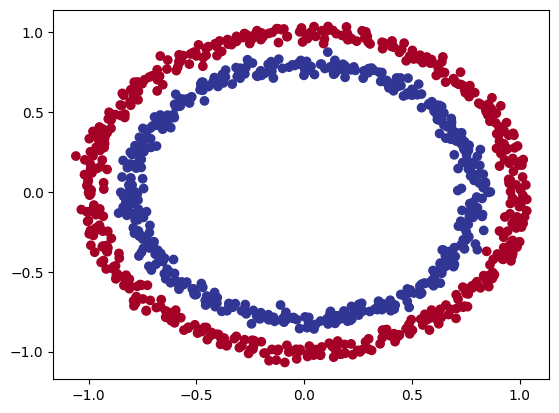

In [75]:
# Visualize the data
plt.scatter(x = X[:,0], y = X[:,1], c = y, cmap = plt.cm.RdYlBu)

### Check input and output shapes

In [76]:
X.shape, y.shape

((1000, 2), (1000,))

In [77]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f'Values for one sample of X: {X_sample} and the same for y: {y_sample}')
print(f'Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}')

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### Turn data into tensors and create train and test splits

In [78]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [79]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### Build a model

Build a model to classify the red and blue dots

To do so, we want to:
1. Setup device agnostic code so our code will run on a GPU if it exists
2. Construct a model (by subcalssing `nn.Module`)
3. Define a loss function and optimzer 
4. Create a training and test loop

In [80]:
from torch import nn

# Make device agnostic code:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Now we want to construct a model that:
1. Subclass `nn.Module`
1. Create 2 `nn.Linear()` that are capable of handling the shapes of our data
1. Define a `forward` method that outlines our forward pass
1. Initiate an instance of our model class and send it to the target `device`

In [81]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

        # self.two_linear_layers = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=5),
        #     nn.Linear(in_features=5, out_features=1)
        # )
    
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output
        # return self.two_linear_layers(x)


model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [82]:
# We can replicate the model above using nn.Squential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [83]:
# Setup the Loss function & optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

In [84]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

### Train the model

1. Forward pass
1. Calculate the loss
1. Optimizer zero grad
1. Loss backward (backpropagation)
1. Optimizer step

Raw outputs are going to be raw **logits**.

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classficitaion). 

Then we can convert our model's prediction probabilites to **predictions labels** by either rounding them or taking the `argmax()` (for softmax activation).


### Building a training and testing loop

In [85]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

# Put data to target device
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logits -> pred probs -> pred labels

    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the test loss/ accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out whats happening
    if epoch % 10 == 0:
        print(f'Epcoh: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {loss:.4f}, Test Acc: {acc:.2f}%')
        

Epcoh: 0 | Loss: 0.7023, Acc: 57.38% | Test Loss: 0.7023, Test Acc: 57.38%
Epcoh: 10 | Loss: 0.6970, Acc: 52.75% | Test Loss: 0.6970, Test Acc: 52.75%
Epcoh: 20 | Loss: 0.6951, Acc: 51.62% | Test Loss: 0.6951, Test Acc: 51.62%
Epcoh: 30 | Loss: 0.6943, Acc: 51.12% | Test Loss: 0.6943, Test Acc: 51.12%
Epcoh: 40 | Loss: 0.6939, Acc: 50.38% | Test Loss: 0.6939, Test Acc: 50.38%
Epcoh: 50 | Loss: 0.6937, Acc: 50.50% | Test Loss: 0.6937, Test Acc: 50.50%
Epcoh: 60 | Loss: 0.6935, Acc: 50.38% | Test Loss: 0.6935, Test Acc: 50.38%
Epcoh: 70 | Loss: 0.6934, Acc: 50.50% | Test Loss: 0.6934, Test Acc: 50.50%
Epcoh: 80 | Loss: 0.6933, Acc: 50.38% | Test Loss: 0.6933, Test Acc: 50.38%
Epcoh: 90 | Loss: 0.6933, Acc: 50.25% | Test Loss: 0.6933, Test Acc: 50.25%


### Make predictions and evaluate the model

From the metrics, our model doesn't seem to be learning anything. 


In [86]:
# Import a function called `plot_decision_boundary()`
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
    print('helper_functions.py already exists. Skipping download.')
else:
    print("Download helper_functions.py")
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open("helper_functions.py", 'wb') as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists. Skipping download.


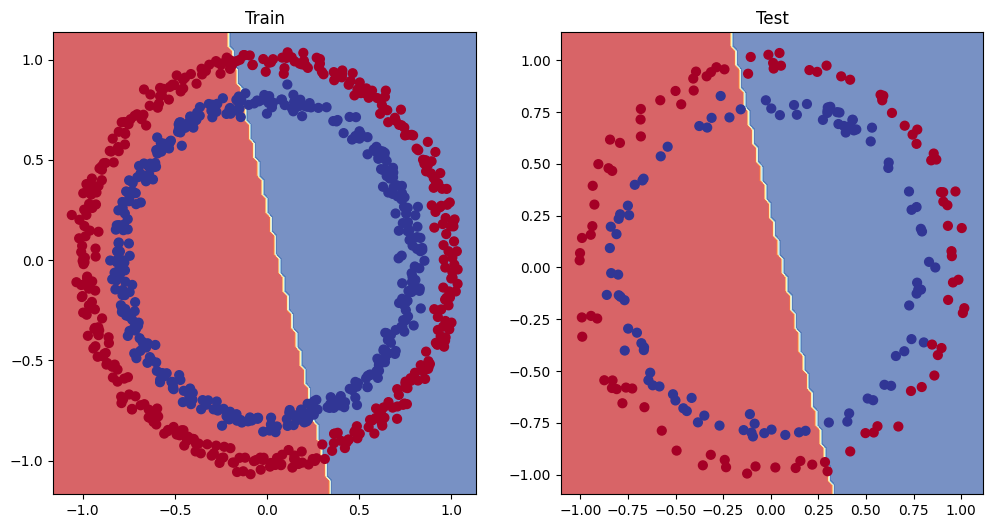

In [87]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

### Improving a model

* Add more layers - give model more chances to learn about patterns in the data
* Add more hidden units - fo from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

In [104]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=64)
        self.layer_2 = nn.Linear(in_features=64, out_features=32)
        self.layer_3 = nn.Linear(in_features=32, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_3 = CircleModelV1().to(device)


In [106]:
# Set up loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr = 0.1)

In [107]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
    model_3.train()

    # Forward pass
    y_logits = model_3(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # Calculate the loss & accuracy
    loss = loss_fn(y_logits, y_train)
    acc_train = accuracy_fn(y_true=y_train, y_pred=y_preds)

    # Zero grad
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Evaluate model
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze(dim = 1)
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        acc_test = accuracy_fn(y_true=y_test, y_pred=test_preds)
    
    if epoch%10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc_train:.2f}% | Test loss: {test_loss:.4f}, Test acc: {acc_test:.2f}%')


Epoch: 0 | Loss: 0.6930, Acc: 50.00% | Test loss: 0.6913, Test acc: 50.00%
Epoch: 10 | Loss: 0.6914, Acc: 50.25% | Test loss: 0.6905, Test acc: 50.00%
Epoch: 20 | Loss: 0.6902, Acc: 54.87% | Test loss: 0.6899, Test acc: 53.00%
Epoch: 30 | Loss: 0.6890, Acc: 55.25% | Test loss: 0.6893, Test acc: 54.00%
Epoch: 40 | Loss: 0.6878, Acc: 56.75% | Test loss: 0.6886, Test acc: 54.00%
Epoch: 50 | Loss: 0.6866, Acc: 61.62% | Test loss: 0.6881, Test acc: 61.50%
Epoch: 60 | Loss: 0.6855, Acc: 68.88% | Test loss: 0.6876, Test acc: 69.50%
Epoch: 70 | Loss: 0.6844, Acc: 73.75% | Test loss: 0.6870, Test acc: 72.50%
Epoch: 80 | Loss: 0.6832, Acc: 76.62% | Test loss: 0.6865, Test acc: 75.50%
Epoch: 90 | Loss: 0.6820, Acc: 77.25% | Test loss: 0.6859, Test acc: 74.50%
Epoch: 100 | Loss: 0.6807, Acc: 77.38% | Test loss: 0.6852, Test acc: 73.50%
Epoch: 110 | Loss: 0.6792, Acc: 77.00% | Test loss: 0.6843, Test acc: 72.00%
Epoch: 120 | Loss: 0.6772, Acc: 75.38% | Test loss: 0.6830, Test acc: 68.50%
Epoch: 130

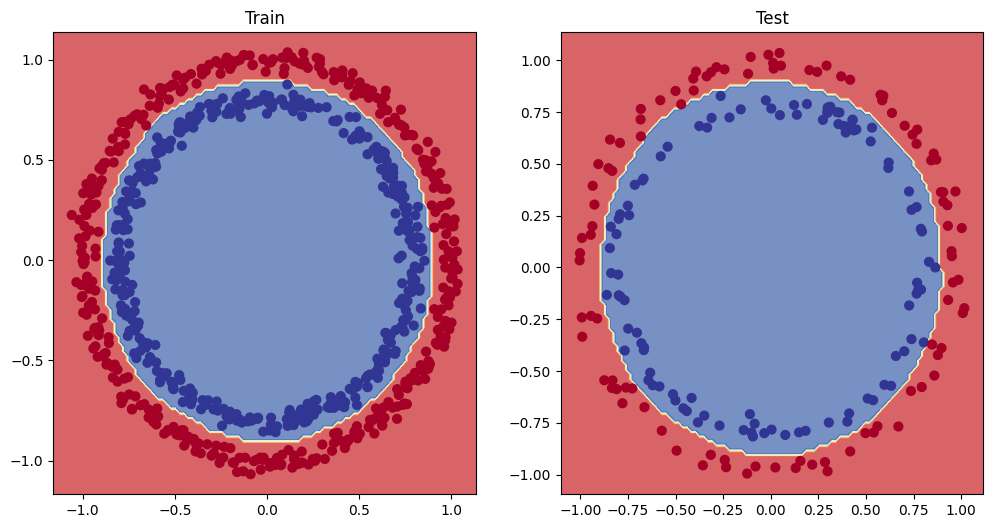

In [108]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_3, X_test, y_test)